In [ ]:
#importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import tensorflow as tf
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline



import warnings
warnings.filterwarnings('ignore')

In [ ]:
#importing the dataset

df = pd.read_csv('/content/drive/MyDrive/Machine Learning Final Project/cleaned_data.csv')
df.head()

,gender,yr_level,current_program,hs_type,parents_educ,parents_fields,reloc,travel_time_to_campus,financial_source,ave_household_income,...,ave_study_hours,college_preparedness,pstrength_stem,pstrength_abm,pstrength_techvoc,pstrength_humss,passion,careerpath_interest,hs_favesub,hs_extracurr
0,Female,4,applied mathematics - data science,Private,College Graduate,"Health and Medicine, Business and Management, ...",Yes,15,Parents,150000.0,...,3.0,5,5,5,2,2,5,STEM,Mathematics,"Sports, Music and Dancing, Arts and Crafts, Dr..."
1,Male,4,applied mathematics - data science,Science High School,High School Graduate,STEM,Yes,12,Parents,50000.0,...,4.0,3,5,4,3,3,5,"Business and Management, STEM","Mathematics, Science, History, Literature, Tec...","Arts and Crafts, Science Clubs, Coding and Tec..."
2,Male,4,nutrition and dietetics,Science High School,Postgraduate,"Education and Academia, Law and Public Service",Yes,10,Parents,75000.0,...,0.5,3,3,2,3,2,3,"Health and Medicine, STEM, Law and Public Service","Science, Literature",Journalism
3,Male,4,chemical engineering,Science High School,High School Graduate,"Education and Academia, Law and Public Service",No,45,Parents,40000.0,...,2.5,3,3,3,3,4,5,"Business and Management, STEM, Education and A...","Science, History, Physical Education",Sports
4,Male,4,chemical engineering,Technical,College Graduate,"Health and Medicine, Hospitality and Service I...",No,20,Parents,100000.0,...,1.5,2,3,2,4,2,4,"Health and Medicine, Business and Management, ...","Science, History, Technology","Sports, Drama and Theater, Science Clubs, Volu..."


##**Feature Engineering and Scaling**



In [ ]:
def engineer_features(df):
    # Create new features
    df['has_stem_background'] = df['parents_fields'].str.contains('STEM').astype(int)
    df['extracurr_count'] = df['hs_extracurr'].str.count(',') + 1
    df['favesub_count'] = df['hs_favesub'].str.count(',') + 1

    # Create strength score (average of all pstrength columns)
    strength_cols = [col for col in df.columns if 'pstrength' in col]
    df['avg_strength'] = df[strength_cols].mean(axis=1)

    return df

# Preprocess the data
def preprocess_data(df, target_column):
    # Engineer features
    df = engineer_features(df)

    # Separate features and target
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    # Split categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    numerical_cols = [
    'travel_time_to_campus', 'ave_household_income',
    'financial_preparedness', 'hs_gpa', 'ave_study_hours',
    'passion', 'has_stem_background', 'extracurr_count', 'favesub_count', 'avg_strength']


    # Modify the preprocessor to output dense arrays
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, preprocessor

In [ ]:
#Preprocessing the data and creating features
target = 'current_program'
X_train, X_test, y_train, y_test, preprocessor = preprocess_data(df, target)

In [ ]:
df

,gender,yr_level,current_program,hs_type,parents_educ,parents_fields,reloc,travel_time_to_campus,financial_source,ave_household_income,...,pstrength_techvoc,pstrength_humss,passion,careerpath_interest,hs_favesub,hs_extracurr,has_stem_background,extracurr_count,favesub_count,avg_strength
0,Female,4,applied mathematics - data science,Private,College Graduate,"Health and Medicine, Business and Management, ...",Yes,15,Parents,150000.0,...,2,2,5,STEM,Mathematics,"Sports, Music and Dancing, Arts and Crafts, Dr...",1,7,1,3.50
1,Male,4,applied mathematics - data science,Science High School,High School Graduate,STEM,Yes,12,Parents,50000.0,...,3,3,5,"Business and Management, STEM","Mathematics, Science, History, Literature, Tec...","Arts and Crafts, Science Clubs, Coding and Tec...",1,5,5,3.75
2,Male,4,nutrition and dietetics,Science High School,Postgraduate,"Education and Academia, Law and Public Service",Yes,10,Parents,75000.0,...,3,2,3,"Health and Medicine, STEM, Law and Public Service","Science, Literature",Journalism,0,1,2,2.50
3,Male,4,chemical engineering,Science High School,High School Graduate,"Education and Academia, Law and Public Service",No,45,Parents,40000.0,...,3,4,5,"Business and Management, STEM, Education and A...","Science, History, Physical Education",Sports,0,1,3,3.25
4,Male,4,chemical engineering,Technical,College Graduate,"Health and Medicine, Hospitality and Service I...",No,20,Parents,100000.0,...,4,2,4,"Health and Medicine, Business and Management, ...","Science, History, Technology","Sports, Drama and Theater, Science Clubs, Volu...",0,5,3,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Male,2,telecommunication engineering,Public,High School Graduate,Hospitality and Service Industry,Yes,10,Parents,35000.0,...,5,1,4,"STEM, Want to explore VLSI industry","Mathematics, Science, Technology, Physical Edu...","Sports, Music and Dancing, Science Clubs, Phot...",0,4,4,2.75
92,Female,4,computer engineering,Private,Postgraduate,"Health and Medicine, Education and Academia",Yes,35,Parents,35000.0,...,3,3,2,STEM,Mathematics,Debate and Public Speaking,0,1,1,2.25
93,Male,1,computer science,Public,College Graduate,"Health and Medicine, STEM",Yes,15,Parents,40000.0,...,5,4,5,"Business and Management, STEM, Education and A...","Mathematics, Science, Technology","Sports, Arts and Crafts, Debate and Public Spe...",1,6,3,4.50
94,Female,1,electrical engineering,Public,No formal education,Hospitality and Service Industry,No,50,Parents,17600.0,...,4,5,3,"STEM, Education and Academia","History, Social Studies, Technology","Writing, Debate and Public Speaking",0,2,3,3.25


##**Model Implementation, Evaluation, and Analysis**

**Logistic Regression Implementation**

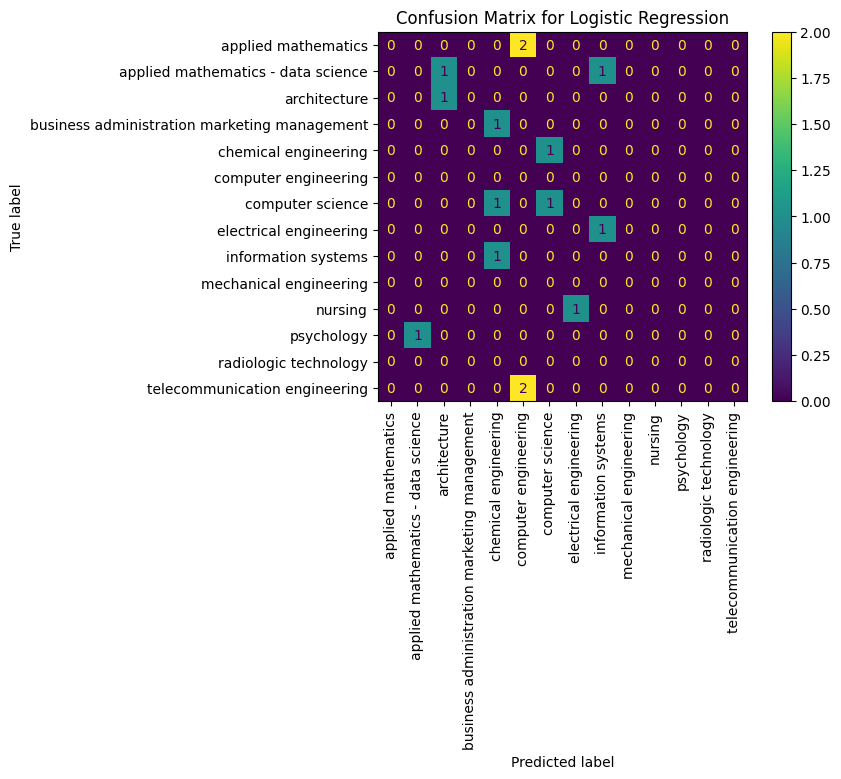

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.1,0.575,0.1,0.083333


In [ ]:
results_list = []

# Update the model and its name
model = LogisticRegression(max_iter=1000, random_state = 32)
model_name = "Logistic Regression"

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Display results
results_list.append({
    "Model": model_name,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix for {model_name}')
plt.xticks(rotation=90)
plt.show()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)
results_df

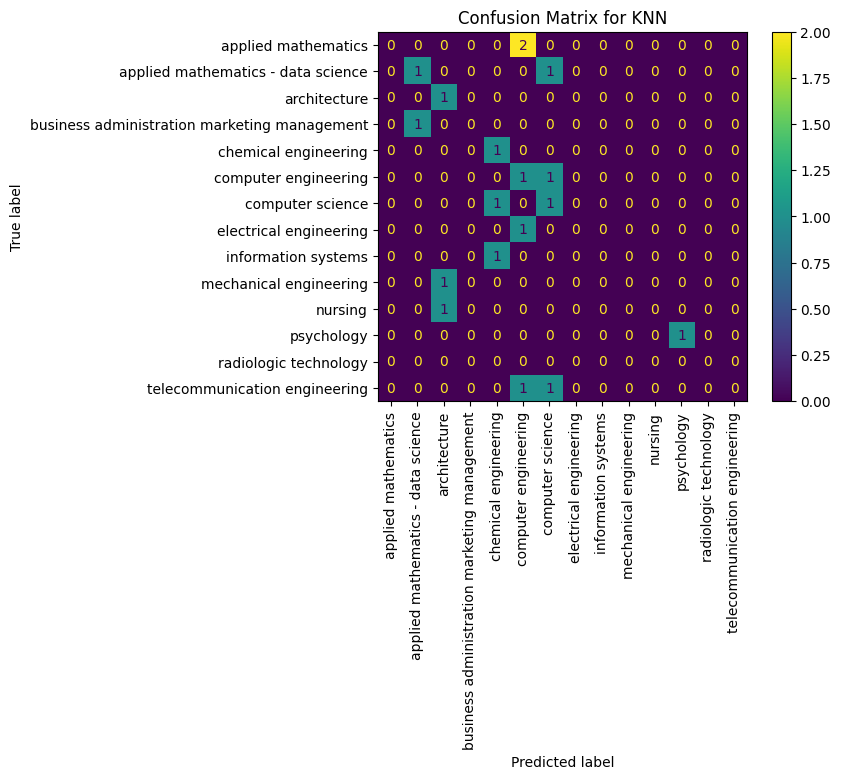

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.1,0.575000,0.1,0.083333
1,KNN,0.3,0.728333,0.3,0.211905


In [ ]:
# Update the model and its name
model = KNeighborsClassifier(n_neighbors = 22)
model_name = "KNN"

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Display results
results_list.append({
    "Model": model_name,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix for {model_name}')
plt.xticks(rotation=90)
plt.show()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)
results_df

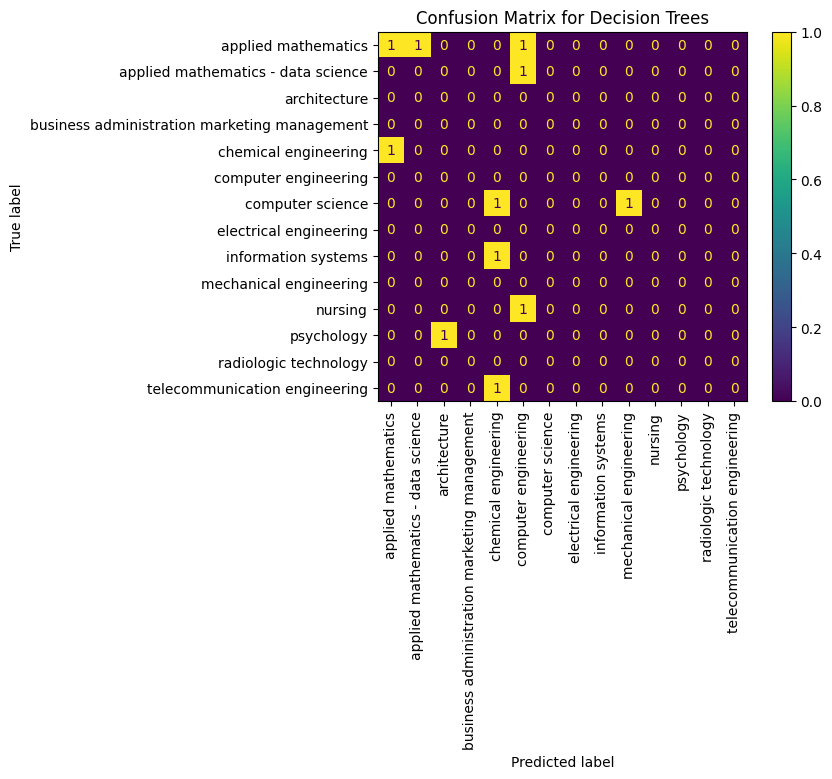

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.10,0.575000,0.10,0.083333
1,KNN,0.30,0.728333,0.30,0.211905
2,Decision Trees,0.05,0.575000,0.05,0.060000


In [ ]:
# Update the model and its name
model = DecisionTreeClassifier(random_state = 32)
model_name = "Decision Trees"

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Display results
results_list.append({
    "Model": model_name,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix for {model_name}')
plt.xticks(rotation=90)
plt.show()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)
results_df

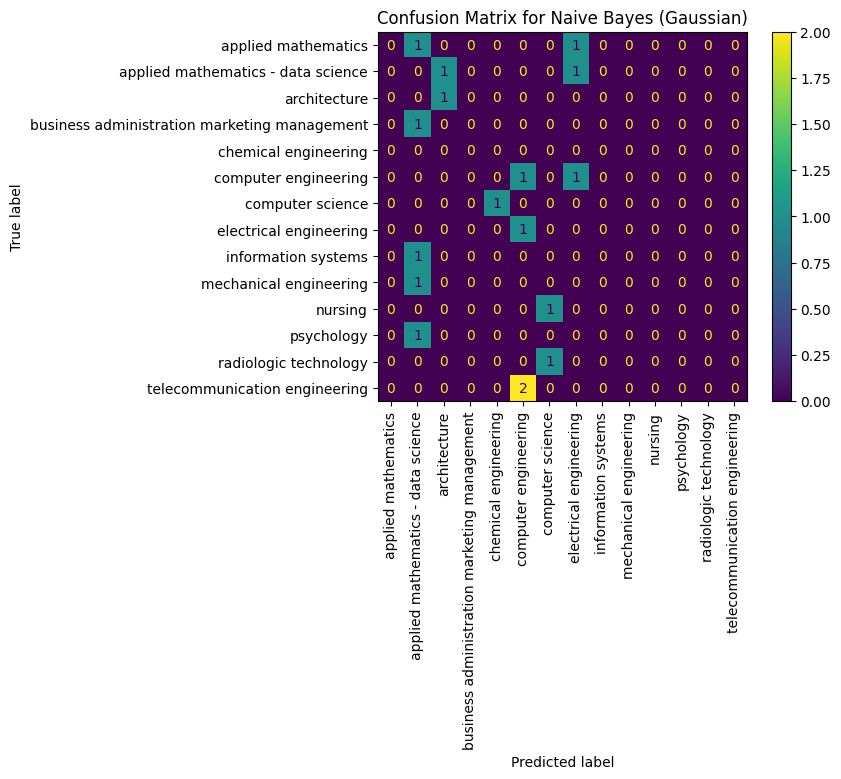

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.10,0.575000,0.10,0.083333
1,KNN,0.30,0.728333,0.30,0.211905
2,Decision Trees,0.05,0.575000,0.05,0.060000
3,Naive Bayes (Gaussian),0.10,0.600000,0.10,0.066667


In [ ]:
# Update the model and its name
model = GaussianNB()
model_name = "Naive Bayes (Gaussian)"

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Display results
results_list.append({
    "Model": model_name,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix for {model_name}')
plt.xticks(rotation=90)
plt.show()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)
results_df

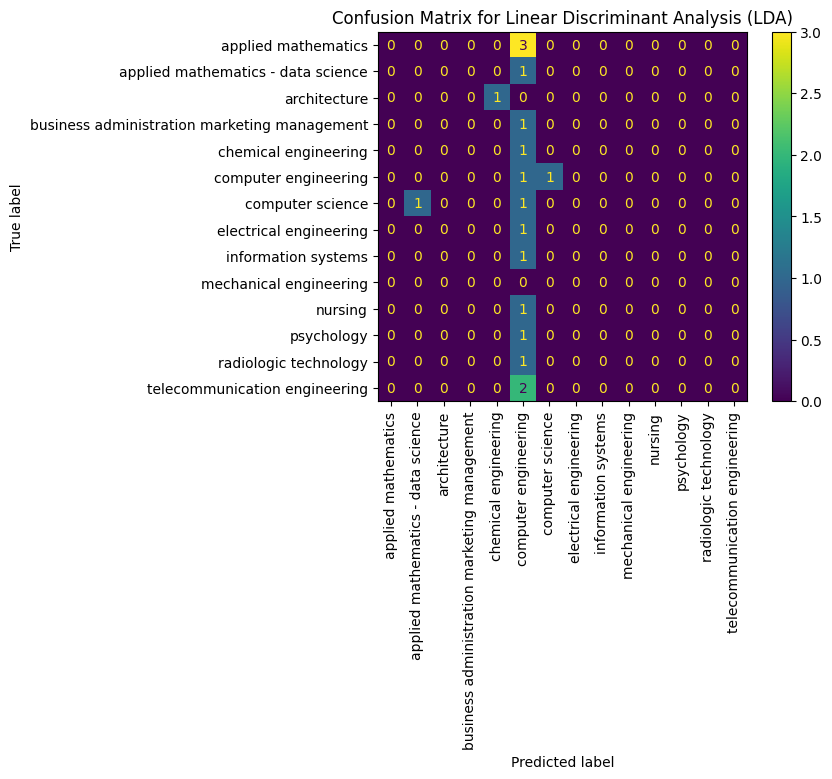

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.10,0.575000,0.10,0.083333
1,KNN,0.30,0.728333,0.30,0.211905
2,Decision Trees,0.05,0.575000,0.05,0.060000
3,Naive Bayes (Gaussian),0.10,0.600000,0.10,0.066667
4,Linear Discriminant Analysis (LDA),0.05,0.656667,0.05,0.011765


In [ ]:
# Update the model and its name
model = LinearDiscriminantAnalysis()
model_name = "Linear Discriminant Analysis (LDA)"

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Display results
results_list.append({
    "Model": model_name,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix for {model_name}')
plt.xticks(rotation=90)
plt.show()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)
results_df

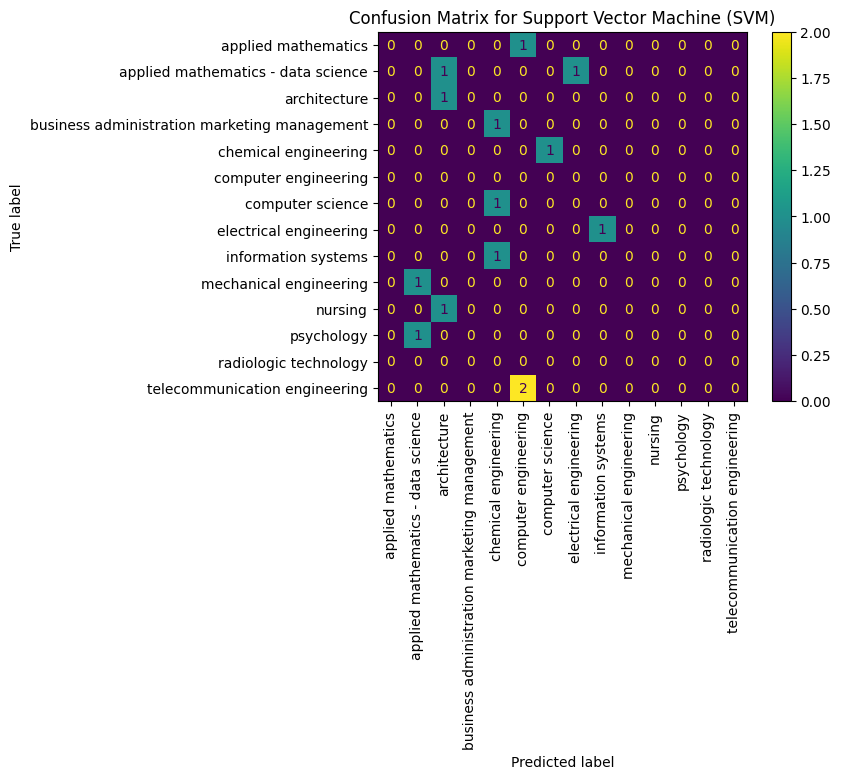

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.10,0.575000,0.10,0.083333
1,KNN,0.30,0.728333,0.30,0.211905
2,Decision Trees,0.05,0.575000,0.05,0.060000
3,Naive Bayes (Gaussian),0.10,0.600000,0.10,0.066667
4,Linear Discriminant Analysis (LDA),0.05,0.656667,0.05,0.011765
5,Support Vector Machine (SVM),0.05,0.516667,0.05,0.025000


In [ ]:
# Update the model and its name
model = SVC(kernel='linear', random_state=42)
model_name = "Support Vector Machine (SVM)"

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Display results
results_list.append({
    "Model": model_name,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix for {model_name}')
plt.xticks(rotation=90)
plt.show()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)
results_df

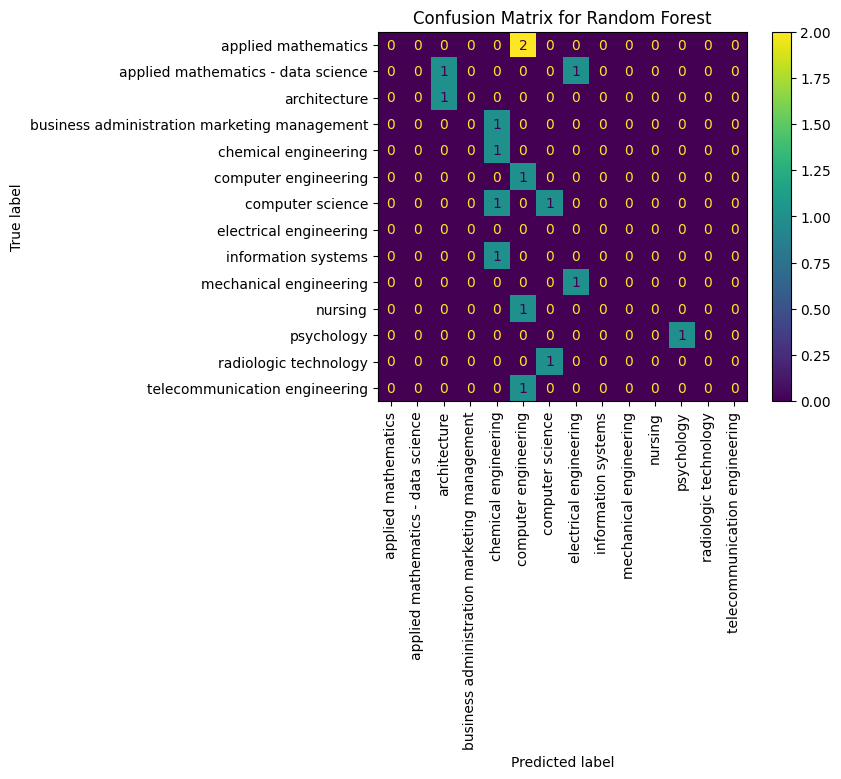

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.10,0.575000,0.10,0.083333
1,KNN,0.30,0.728333,0.30,0.211905
2,Decision Trees,0.05,0.575000,0.05,0.060000
3,Naive Bayes (Gaussian),0.10,0.600000,0.10,0.066667
4,Linear Discriminant Analysis (LDA),0.05,0.656667,0.05,0.011765
5,Support Vector Machine (SVM),0.05,0.516667,0.05,0.025000
6,Random Forest,0.25,0.757500,0.25,0.181905


In [ ]:
model = RandomForestClassifier(n_estimators = 500, max_depth = 50, random_state=42)
model_name = "Random Forest"

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Display results
results_list.append({
    "Model": model_name,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix for {model_name}')
plt.xticks(rotation=90)
plt.show()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)
results_df

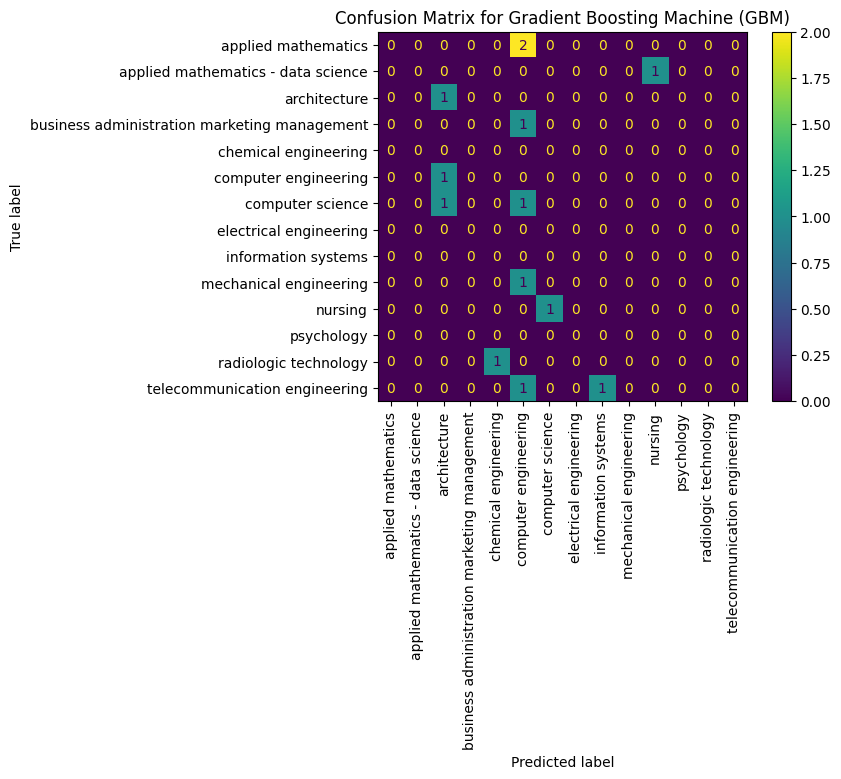

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.10,0.575000,0.10,0.083333
1,KNN,0.30,0.728333,0.30,0.211905
2,Decision Trees,0.05,0.575000,0.05,0.060000
3,Naive Bayes (Gaussian),0.10,0.600000,0.10,0.066667
4,Linear Discriminant Analysis (LDA),0.05,0.656667,0.05,0.011765
5,Support Vector Machine (SVM),0.05,0.516667,0.05,0.025000
6,Random Forest,0.25,0.757500,0.25,0.181905
7,Gradient Boosting Machine (GBM),0.05,0.616667,0.05,0.025000


In [ ]:
model = GradientBoostingClassifier(n_estimators = 100, max_depth = 50, random_state=42)
model_name = "Gradient Boosting Machine (GBM)"

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Display results
results_list.append({
    "Model": model_name,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix for {model_name}')
plt.xticks(rotation=90)
plt.show()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)
results_df

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

def create_feedforward_neural_network(input_shape, num_classes):

    model = Sequential([
        # Input layer and first hidden layer
        Dense(64, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),

        # Add dropout to prevent overfitting
        Dropout(0.3),

        # Second hidden layer
        Dense(32, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),

        # Add another dropout layer
        Dropout(0.2),

        # Output layer with softmax activation for multi-class classification
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Adaptive learning rate
        loss='categorical_crossentropy',      # Good for multi-class problems
        metrics=['accuracy']                  # Track accuracy during training
    )

    return model

def prepare_target_for_neural_network(y_train, y_test):
    # Create a label encoder to convert categorical labels to numerical
    label_encoder = LabelEncoder()

    # Fit the encoder on the entire dataset to ensure consistent encoding
    all_programs = pd.concat([y_train, y_test])
    label_encoder.fit(all_programs)

    # Transform training and testing labels
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Convert to categorical (one-hot encoding)
    y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded)
    y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded)

    return y_train_categorical, y_test_categorical, label_encoder

def train_neural_network(X_train, X_test, y_train, y_test):
    # Preprocess training data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Prepare target variable
    y_train_categorical, y_test_categorical, label_encoder = prepare_target_for_neural_network(y_train, y_test)

    # Determine input shape and number of classes
    input_shape = X_train_processed.shape[1]
    num_classes = y_train_categorical.shape[1]

    # Create the model
    model = create_feedforward_neural_network(input_shape, num_classes)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',     # Monitor validation loss
        patience=10,            # Stop if no improvement for 10 epochs
        restore_best_weights=True  # Restore model weights from best epoch
    )

    # Train the model
    history = model.fit(
        X_train_processed, y_train_categorical,
        validation_split=0.1,    # Use 20% of training data for validation
        epochs=1000,               # Maximum number of epochs
        batch_size=32,            # Number of samples per gradient update
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(
        X_test_processed, y_test_categorical, verbose=0
    )
    print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

    return model, history, label_encoder

# Train the neural network
model, history, label_encoder = train_neural_network(X_train, X_test, y_train, y_test)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.0377 - loss: 3.7567 - val_accuracy: 0.2500 - val_loss: 3.6252
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0797 - loss: 3.7413 - val_accuracy: 0.2500 - val_loss: 3.6174
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0528 - loss: 3.7139 - val_accuracy: 0.1250 - val_loss: 3.6115
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0568 - loss: 3.6508 - val_accuracy: 0.1250 - val_loss: 3.6063
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1057 - loss: 3.6092 - val_accuracy: 0.0000e+00 - val_loss: 3.6020
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.0797 - loss: 3.5841 - val_accuracy: 0.0000e+00 - val_loss: 3.5972
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0494 - loss: 3.5822 - val_accuracy: 0.0000e+00 - val_loss: 3.5930
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1023 - loss: 3.5555 - val_accura